In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp



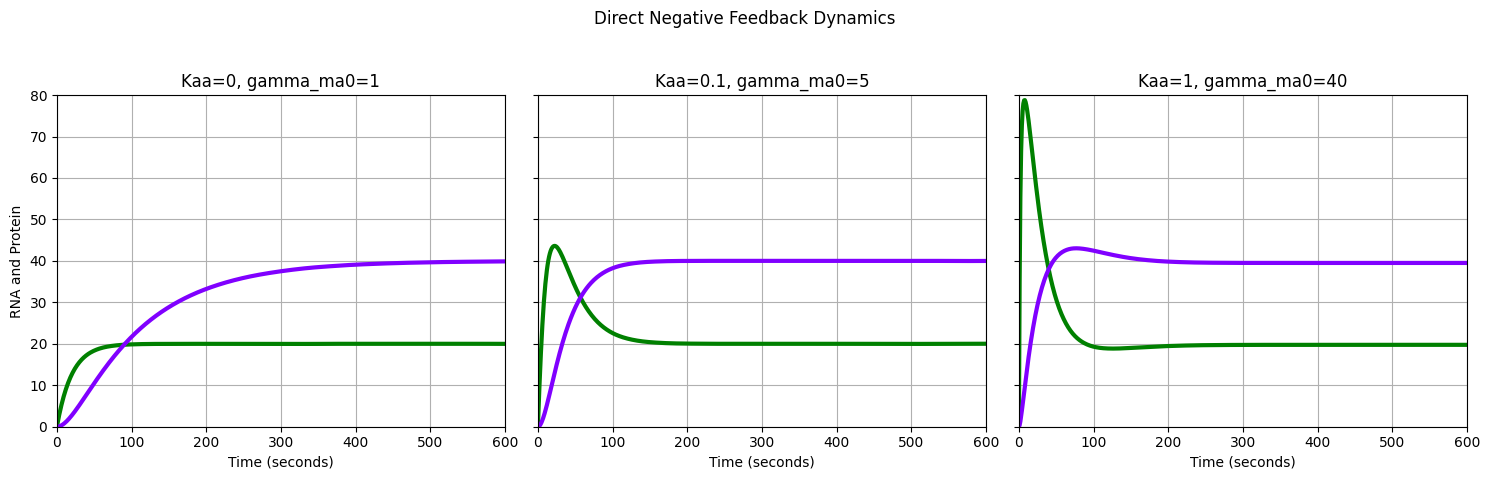

In [3]:


# Define parameters for each scenario
params = [
    {'Kaa': 0, 'gamma_ma0': 1},
    {'Kaa': 0.1, 'gamma_ma0': 5},
    {'Kaa': 1, 'gamma_ma0': 40},
]

# ODE system for each parameter set
def dxdt(t, x, Kaa, gamma_ma0):
    ma, pa = x
    gamma_ma = gamma_ma0 / (1 + Kaa * pa)
    dmadt = gamma_ma - delta_ma * ma
    dpadt = gamma_pa * ma - delta_pa * pa
    return [dmadt, dpadt]

delta_ma = 0.05
gamma_pa = 0.02
delta_pa = 0.01

# Plot settings
fig, axs = plt.subplots(1, len(params), figsize=(15, 5), sharey=True)
fig.suptitle('Direct Negative Feedback Dynamics')

for iParam, param in enumerate(params):
    Kaa = param['Kaa']
    gamma_ma0 = param['gamma_ma0']
    
    # Solve the ODE system
    sol = solve_ivp(dxdt, [0, 600], [0, 0], args=(Kaa, gamma_ma0), dense_output=True, t_eval=np.linspace(0, 600, 600))
    
    # Plotting
    axs[iParam].plot(sol.t, sol.y[0], '-g', linewidth=3)  # RNA in green
    axs[iParam].plot(sol.t, sol.y[1], '-', color=[0.5, 0, 1], linewidth=3)  # Protein in purple
    axs[iParam].set_xlim([0, 600])
    axs[iParam].set_ylim([0, 80])
    axs[iParam].set_xlabel('Time (seconds)')
    axs[iParam].set_title(f'Kaa={Kaa}, gamma_ma0={gamma_ma0}')
    axs[iParam].grid(True)

axs[0].set_ylabel('RNA and Protein')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


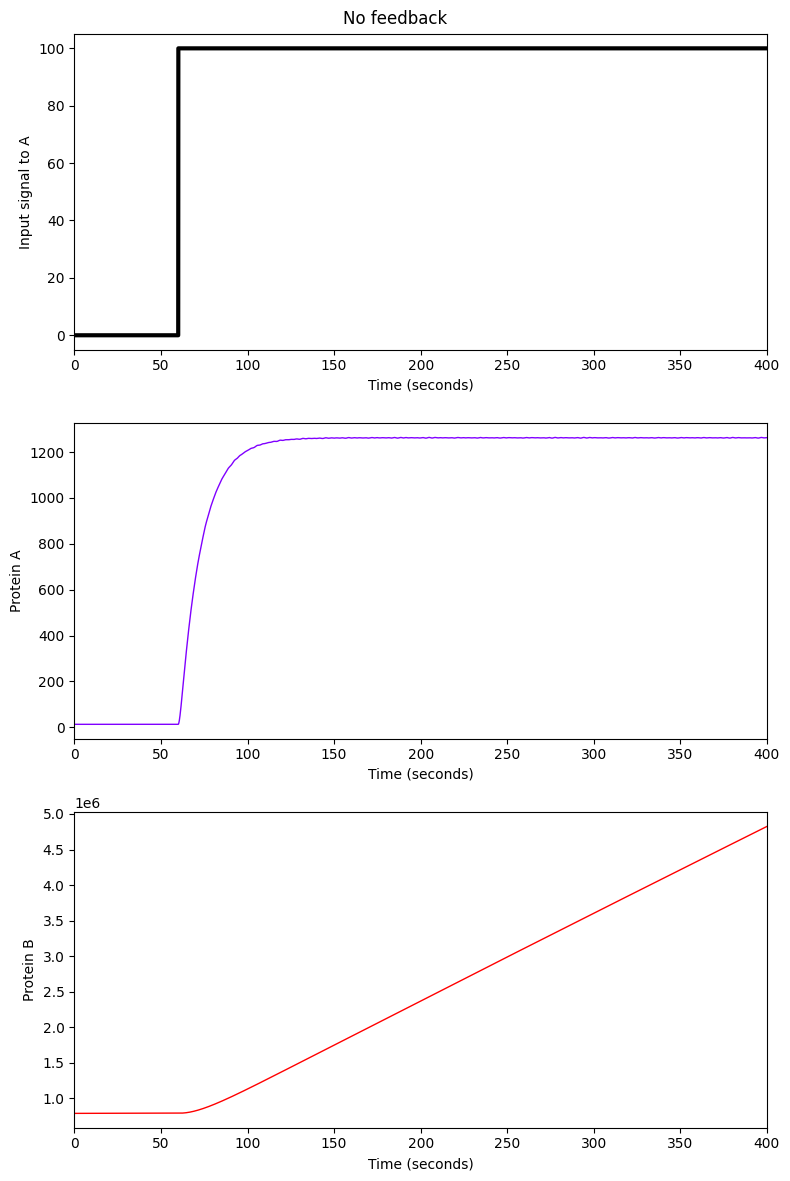

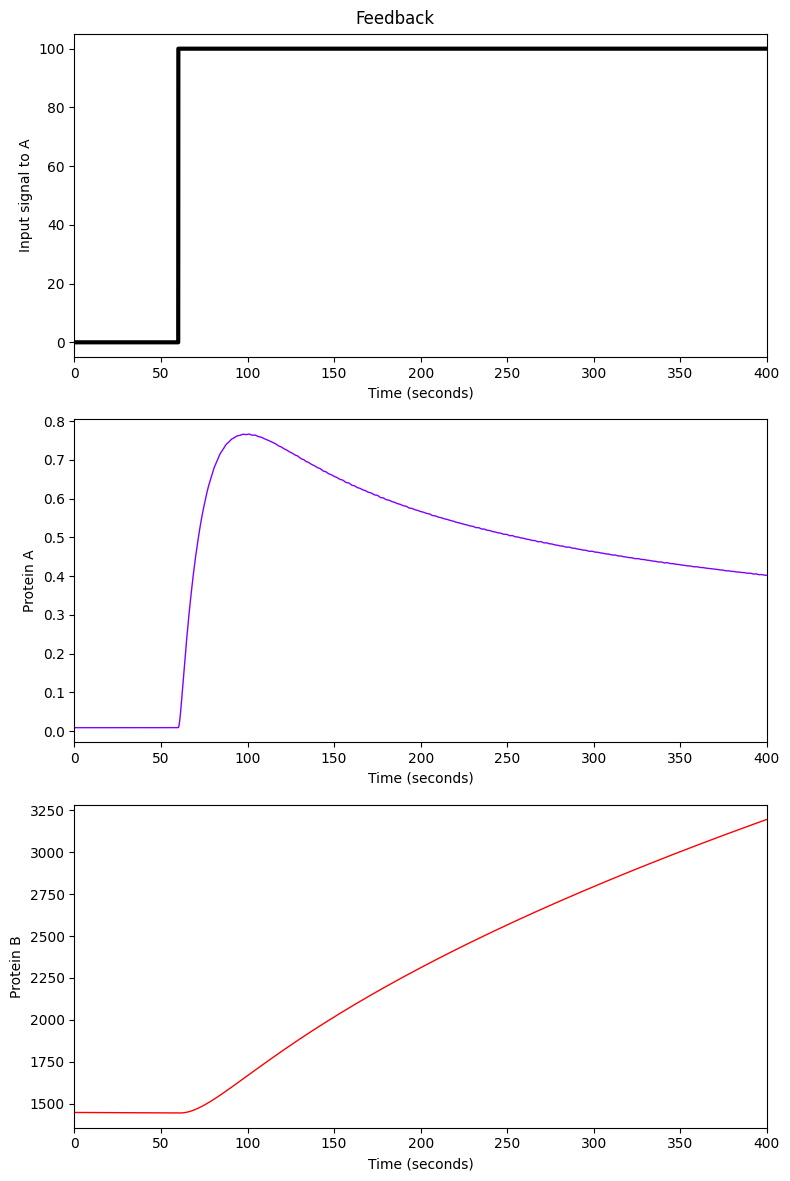

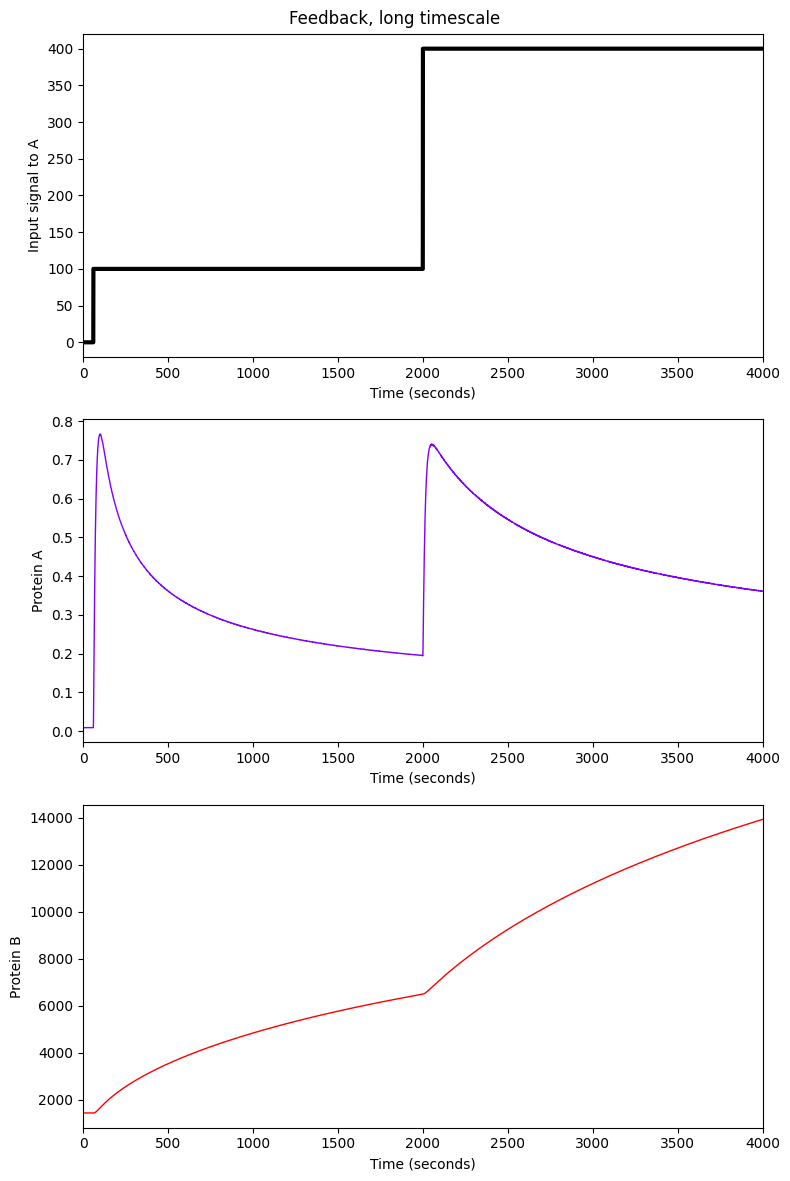

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters for scenarios
params = [
    {'title': 'No feedback', 'Kba': 0, 'Kab': 1e4, 'tMax': 400},
    {'title': 'Feedback', 'Kba': 1.0, 'Kab': 1e4, 'tMax': 400},
    {'title': 'Feedback, long timescale', 'Kba': 1.0, 'Kab': 1e4, 'tMax': 4000},
]

# An input signal, e.g., externally-induced production
def i(t):
    return 0*(t < 60) + 100*(t > 60) + 300*(t > 2000)

# Simulation for each parameter set
for param in params:
    Kba = param['Kba']
    Kab = param['Kab']
    tMax = param['tMax']

    # Dynamic functions
    def gamma_ma(pb, t):
        return 1. / (1 + Kba * pb) * (1.0 + i(t))

    def gamma_mb(pa):
        return 1e-3 * (1 + Kab * pa)

    # Differential equations
    def dxdt(t, x):
        ma, pa, mb, pb = x
        return [
            gamma_ma(pb, t) - delta_ma * ma,
            gamma_pa * ma - delta_pa * pa,
            gamma_mb(pa) - delta_mb * mb,
            gamma_pb * mb - delta_pb * pb
        ]

    delta_ma = 0.08
    gamma_pa = 1
    delta_pa = 1
    delta_mb = 1e-4
    gamma_pb = 1
    delta_pb = 1

    initialCondition = [20, 20, 0, 0]

    # Solve the differential equations
    sol = solve_ivp(dxdt, [-10000.0, tMax], initialCondition, dense_output=True, t_eval=np.linspace(0, tMax, 10000))

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    fig.suptitle(param['title'])

    # Input signal to A
    axs[0].plot(sol.t, i(sol.t), '-k', linewidth=3)
    axs[0].set_ylabel('Input signal to A')
    axs[0].set_xlabel('Time (seconds)')
    axs[0].set_xlim([0, tMax])

    # Protein A
    axs[1].plot(sol.t, sol.y[1], '-', color=[0.5, 0, 1], linewidth=1)
    axs[1].set_ylabel('Protein A')
    axs[1].set_xlabel('Time (seconds)')
    axs[1].set_xlim([0, tMax])

    # Protein B
    axs[2].plot(sol.t, sol.y[2], '-r', linewidth=1)
    axs[2].set_ylabel('Protein B')
    axs[2].set_xlabel('Time (seconds)')
    axs[2].set_xlim([0, tMax])

    plt.tight_layout()
    plt.show()


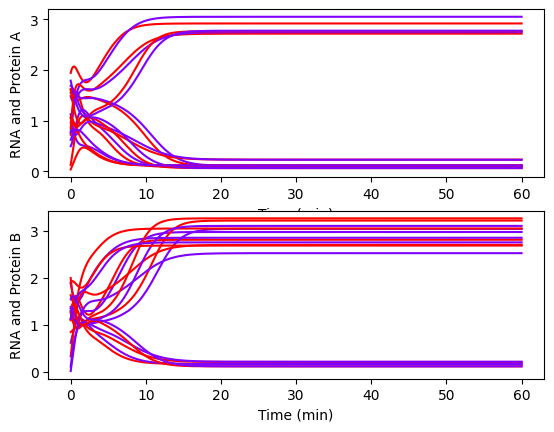

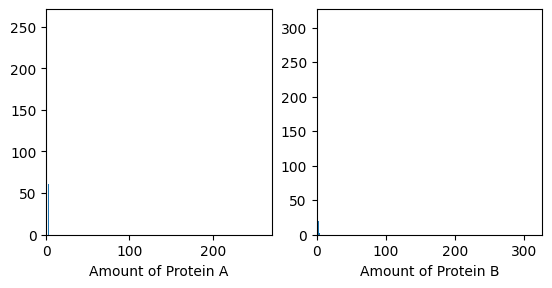

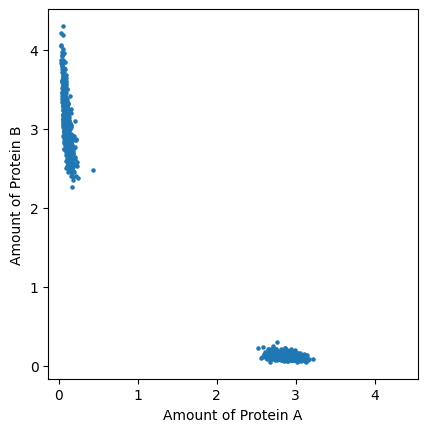

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Settings
noisiness = 0.1
noisiness2 = 0.1
numRuns = 1000
storage_A = np.zeros(numRuns)
storage_B = np.zeros(numRuns)

# Simulation loop
for iRun in range(numRuns):
    
    # Parameter variations
    delta_ma = 1 * (1 + noisiness * np.random.rand())
    gamma_pa = 1 * (1 + noisiness * np.random.rand())
    delta_pa = 1 * (1 + noisiness * np.random.rand())
    
    delta_mb = 1 * (1 + noisiness * np.random.randn())
    gamma_pb = 1 * (1 + noisiness * np.random.rand())
    delta_pb = 1 * (1 + noisiness * np.random.rand())
    
    Kba = 1 * (1 + noisiness2 * np.random.randn())
    Kaa = 0
    gamma_ma = lambda pb: 3 / (1 + abs(Kba * pb) ** 3)
    
    Kab = 1 * (1 + noisiness2 * np.random.randn())
    Kbb = 0
    gamma_mb = lambda pa: 3 / (1 + abs(Kab * pa) ** 3)
    
    # ODE system
    def dxdt(t, x):
        ma, pa, mb, pb = x
        return [
            gamma_ma(pb) - delta_ma * ma,
            gamma_pa * ma - delta_pa * pa,
            gamma_mb(pa) - delta_mb * mb,
            gamma_pb * mb - delta_pb * pb
        ]
    
    initialCondition = 2 * np.random.rand(4)
    
    # Solve ODEs
    sol = solve_ivp(dxdt, [0, 60], initialCondition, method='RK45', t_eval=np.linspace(0, 60, 600))
    
    # Plotting for the first few runs
    if iRun < 9:
        plt.figure(1)
        if iRun == 0:
            plt.subplot(2, 1, 1)
            plt.ylabel('RNA and Protein A')
            plt.xlabel('Time (min)')
            plt.subplot(2, 1, 2)
            plt.ylabel('RNA and Protein B')
            plt.xlabel('Time (min)')
        plt.subplot(2, 1, 1)
        plt.plot(sol.t, sol.y[0], '-r')
        plt.plot(sol.t, sol.y[1], '-', color=[0.5, 0, 1])
        plt.subplot(2, 1, 2)
        plt.plot(sol.t, sol.y[2], '-r')
        plt.plot(sol.t, sol.y[3], '-', color=[0.5, 0, 1])
    
    # Store final concentrations
    storage_A[iRun] = sol.y[1, -1]
    storage_B[iRun] = sol.y[3, -1]

# Histograms
plt.figure(2)
plt.subplot(1, 2, 1)
plt.hist(storage_A, 50)
plt.xlabel('Amount of Protein A')
plt.axis('square')
plt.subplot(1, 2, 2)
plt.hist(storage_B, 50)
plt.xlabel('Amount of Protein B')
plt.axis('square')

# Scatter plot
plt.figure(3)
plt.scatter(storage_A, storage_B, 5)
plt.xlabel('Amount of Protein A')
plt.ylabel('Amount of Protein B')
plt.axis('square')
plt.show()


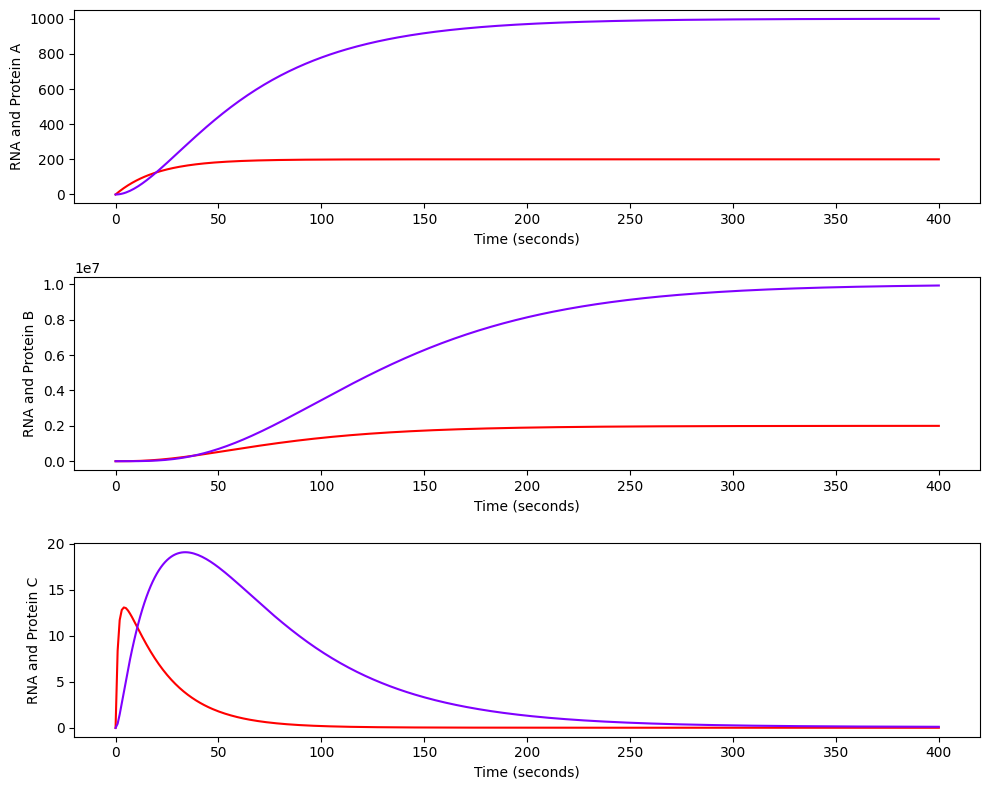

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
delta_ma = 0.05
gamma_pa = 0.1
delta_pa = 0.02

delta_mb = 0.05
gamma_pb = 0.1
delta_pb = 0.02

delta_mc = 0.05
gamma_pc = 0.1
delta_pc = 0.02

gamma_ma = 10

Kab = 10  # Strength (EC50) of activation of B by A
gamma_mb = lambda pa: 10 * (1 + (Kab * pa))

Kac = 10
Kbc = 10  # Strength (IC50) of inhibition of C by B
gamma_mc = lambda pa, pb: 10 * (1 + (Kac * pa)) / (1 + Kbc * pb)

# ODE system
def dxdt(t, x):
    ma, pa, mb, pb, mc, pc = x
    return [
        gamma_ma - delta_ma * ma,
        gamma_pa * ma - delta_pa * pa,
        gamma_mb(pa) - delta_mb * mb,
        gamma_pb * mb - delta_pb * pb,
        gamma_mc(pa, pb) - delta_mc * mc,
        gamma_pc * mc - delta_pc * pc
    ]

initialCondition = [0, 0, 0, 0, 0, 0]

# Solve the ODE system
sol = solve_ivp(dxdt, [0, 400], initialCondition, method='RK45', t_eval=np.linspace(0, 400, 400))

# Plotting
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], '-r', label='RNA A')
plt.plot(sol.t, sol.y[1], '-', color=[0.5, 0, 1], label='Protein A')
plt.ylabel('RNA and Protein A')
plt.xlabel('Time (seconds)')

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[2], '-r', label='RNA B')
plt.plot(sol.t, sol.y[3], '-', color=[0.5, 0, 1], label='Protein B')
plt.ylabel('RNA and Protein B')
plt.xlabel('Time (seconds)')

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[4], '-r', label='RNA C')
plt.plot(sol.t, sol.y[5], '-', color=[0.5, 0, 1], label='Protein C')
plt.ylabel('RNA and Protein C')
plt.xlabel('Time (seconds)')

plt.tight_layout()
plt.show()


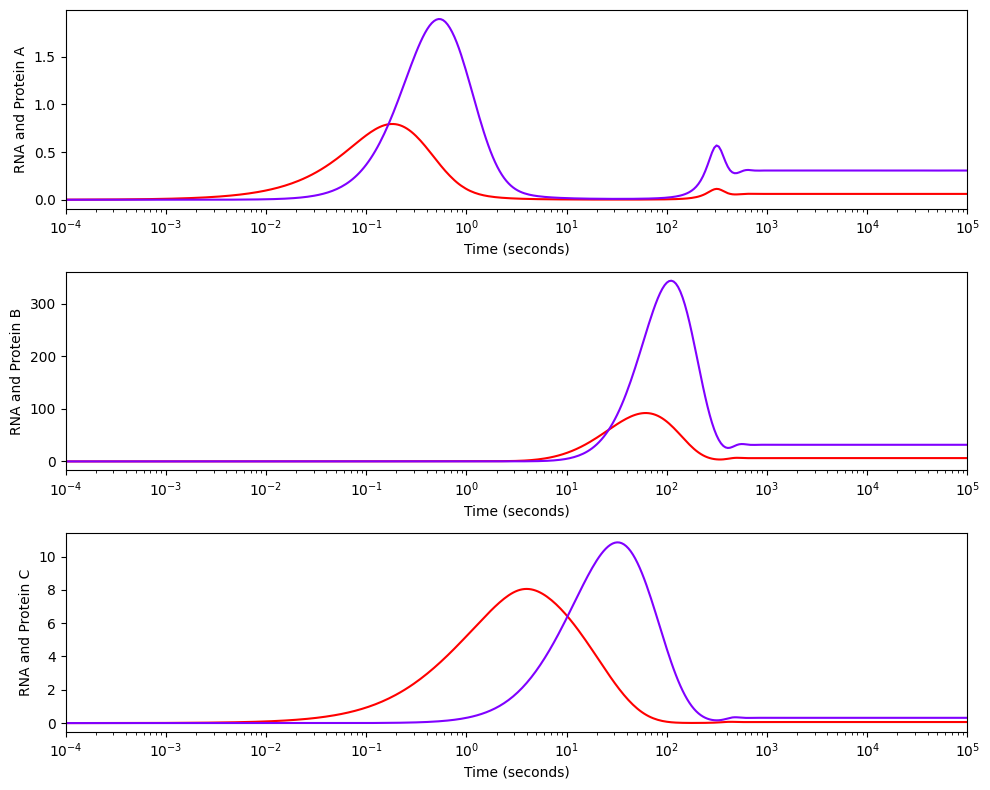

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
delta_ma = 100 * 0.05
gamma_pa = 100 * 0.1
delta_pa = 100 * 0.02

delta_mb = 0.05
gamma_pb = 0.1
delta_pb = 0.02

delta_mc = 0.05
gamma_pc = 0.1
delta_pc = 0.02

Kca = 100  # Strength (IC50) of inhibition of A by C
Kab = 100  # Strength (IC50) of inhibition of B by A
Kbc = 100  # Strength (IC50) of inhibition of C by B

# Dynamic functions
gamma_ma = lambda pc: 10 / (1 + (Kca * pc))
gamma_mb = lambda pa: 10 / (1 + (Kab * pa))
gamma_mc = lambda pb: 10 / (1 + (Kbc * pb))

# ODE system
def dxdt(t, x):
    ma, pa, mb, pb, mc, pc = x
    return [
        gamma_ma(pc) - delta_ma * ma,
        gamma_pa * ma - delta_pa * pa,
        gamma_mb(pa) - delta_mb * mb,
        gamma_pb * mb - delta_pb * pb,
        gamma_mc(pb) - delta_mc * mc,
        gamma_pc * mc - delta_pc * pc
    ]

initialCondition = [0, 0, 0, 0, 0, 0]

# Solve the ODE system
sol = solve_ivp(dxdt, [0, 1e5], initialCondition, method='RK45', t_eval=np.logspace(-4, 5, 400))

# Plotting
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], '-r', label='RNA A')
plt.plot(sol.t, sol.y[1], '-', color=[0.5, 0, 1], label='Protein A')
plt.ylabel('RNA and Protein A')
plt.xlabel('Time (seconds)')
plt.xscale('log')
plt.xlim([1e-4, 1e5])

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[2], '-r', label='RNA B')
plt.plot(sol.t, sol.y[3], '-', color=[0.5, 0, 1], label='Protein B')
plt.ylabel('RNA and Protein B')
plt.xlabel('Time (seconds)')
plt.xscale('log')
plt.xlim([1e-4, 1e5])

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[4], '-r', label='RNA C')
plt.plot(sol.t, sol.y[5], '-', color=[0.5, 0, 1], label='Protein C')
plt.ylabel('RNA and Protein C')
plt.xlabel('Time (seconds)')
plt.xscale('log')
plt.xlim([1e-4, 1e5])

plt.tight_layout()
plt.show()
